## **Introduction**

In the digital era, email remains a cornerstone of personal and professional communication. Yet its widespread adoption has amplified the persistent issue of spam—unsolicited messages that congest inboxes and introduce cybersecurity threats. To address these challenges, this project develops an automated spam classification system designed to efficiently differentiate legitimate ("ham") emails from unwanted ("spam") content, enhancing email management and security.

The exercise's core objective is to create a robust classifier by generating discriminative feature sets from tokenized email data. Feature extraction, a pivotal stage in Natural Language Processing, involves identifying linguistic patterns and keyword relevance that inform classification decisions. By optimizing this process and training an accurate model, the system aims to achieve high-precision spam detection, offering a scalable solution to combat evolving email-based threats.


## **Set Parameters and Import Data**

In [30]:
import os
import sys
import random
import nltk
import re
import numpy as np
import pandas as pd

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize, pos_tag
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from nltk.stem import PorterStemmer
# define a feature definition function here
from sklearn.metrics import confusion_matrix, classification_report, recall_score

from matplotlib import pyplot as plt

In [31]:
limitStr= 1000
dirPath = "corpus" 
outputPath = "output"

Extract the data from zip file.

In [32]:
corpus_path = os.getcwd() +'\\'+ dirPath + '.zip'
basepath = os.getcwd()

In [33]:
! tar -xf "$corpus_path" -C "$basepath"

In [34]:
# convert the limit argument from a string to an int
limit = int(limitStr)

# start lists for spam and ham email texts
hamtexts = []
spamtexts = []
os.chdir(os.getcwd() +"\\"+ dirPath)


Read the data from files.

In [35]:
# process all files in directory that end in .txt up to the limit
#    assuming that the emails are sufficiently randomized
for file in os.listdir("./spam"):
  if (file.endswith(".txt")) and (len(spamtexts) < limit):
    # open file for reading and read entire file into a string
    f = open("./spam/"+file, 'r', encoding="latin-1")
    spamtexts.append (f.read())
    f.close()
    
for file in os.listdir("./ham"):
  if (file.endswith(".txt")) and (len(hamtexts) < limit):
    # open file for reading and read entire file into a string
    f = open("./ham/"+file, 'r', encoding="latin-1")
    hamtexts.append (f.read())
    f.close()

In [36]:
# print number emails read
print ("Number of spam files:",len(spamtexts))
print ("Number of ham files:",len(hamtexts))
NTotal = len(spamtexts) + len(hamtexts)

Number of spam files: 1000
Number of ham files: 1000


In [37]:
hamtexts[:3]

['Subject: christmas tree farm pictures\n',
 'Subject: vastar resources , inc .\ngary , production from the high island larger block a - 1 # 2 commenced on\nsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and\n10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .\ngeorge x 3 - 6992\n- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\ndaren j farmer\n12 / 10 / 99 10 : 38 am\nto : carlos j rodriguez / hou / ect @ ect\ncc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect\nsubject : vastar resources , inc .\ncarlos ,\nplease call linda and get everything set up .\ni \' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each\nfollowing day based on my conversations with bill fischer at bmar .\nd .\n- - - - - - - - - - - - - - - - - - - - - - forwarded by daren j farmer / hou / ect 

## **Pre-processing**

### **Tokenize**

In [38]:
# create list of mixed spam and ham email documents as (list of words, label)
emaildocs = []
# add all the spam
for spam in spamtexts:
    tokens = nltk.word_tokenize(spam)
    emaildocs.append((tokens, 'spam'))

# add all the regular emails
for ham in hamtexts:
    tokens = nltk.word_tokenize(ham)
    emaildocs.append((tokens, 'ham'))

# randomize the list
random.shuffle(emaildocs)

### **Remove Stopwords & Special Charachters**

In [39]:
stop_words = set(stopwords.words('english'))
emaildocsCleaned= []

for email, label in emaildocs:
    cleaned_email = [re.sub(r'[^a-zA-Z]', '', word) for word in email]  # Remove non-alphabetic characters
    cleaned_email = [word for word in cleaned_email if word and word not in stop_words]  # Remove any stopwords
    cleaned_email = [word.lower() for word in cleaned_email if len(word)>=4]  # Remove words with length<4
    emaildocsCleaned.append((cleaned_email,label))  # Add cleaned words to the list of sentences

# print a few token lists
for email in emaildocsCleaned[:2]:
    print (email)
    print('\n')

(['subject', 'phillips', 'petroleum', 'forwarded', 'carlos', 'rodriguez', 'vance', 'taylor', 'acton', 'corp', 'enron', 'enron', 'carlos', 'rodriguez', 'brian', 'riley', 'susan', 'smith', 'donald', 'reinhardt', 'melissa', 'graves', 'subject', 'phillips', 'petroleum', 'please', 'generate', 'spot', 'tickets', 'sitara', 'based', 'upon', 'follow', 'phillips', 'petroleum', 'company', 'mmbtu', 'less', 'phillips', 'petroleum', 'company', 'mmbtu', 'less', 'thanks'], 'ham')


(['subject', 'smoke', 'cgfsaw', 'cmdaawlolmrlbw', 'rcmlob', 'gary', 'crew', 'used', 'main', 'characters', 'tell', 'story', 'wild', 'children', 'billy', 'papa', 'tries', 'tell', 'best', 'first', 'confucianism', 'deals', 'rational', 'cosmic', 'order', 'organization', 'worldly', 'affairs', 'four', 'modified', 'varieties', 'last', 'twain'], 'spam')




### **Bag of Words**

Bag of words is a way to convert text into numerical features for machine learning. Each word in the text becomes a feature. The value is True (presence) or False (absence).

In [40]:
# Step 2 Begins here
# continue as usual to get all words and create word features

# Plot a frequency chart for the top 50 nouns/verbs
def plot_fig(word_list, xlab = 'words', n=50):
  tokens, frequencies = zip(*word_list[:n])
  plt.figure(figsize=(16,9))
  plt.bar(tokens, frequencies)
  plt.xticks(rotation=45)
  plt.title(f'Top-{n}-{xlab} by frequency')
  plt.xlabel(xlab)
  plt.ylabel('Frequency')
  plt.tight_layout()
  # Save the plot as an image
  plt.savefig(f"Top_{xlab}.png")

# Create word features
def get_word_features(emails, k=2000, type='words'):
  all_words = []
  for email,label in emails:
      all_words.extend(email)
  word_dist = FreqDist(all_words)
  sorted_word_dist = sorted(word_dist.items(), key=lambda item: item[1], reverse=True)
  top_words = [word for word,freq  in sorted_word_dist[:k]] #select top features
  plot_fig(sorted_word_dist, xlab = type)
  return list(top_words)  # Top 2000 words as features

Select top 2000 words by frequency.

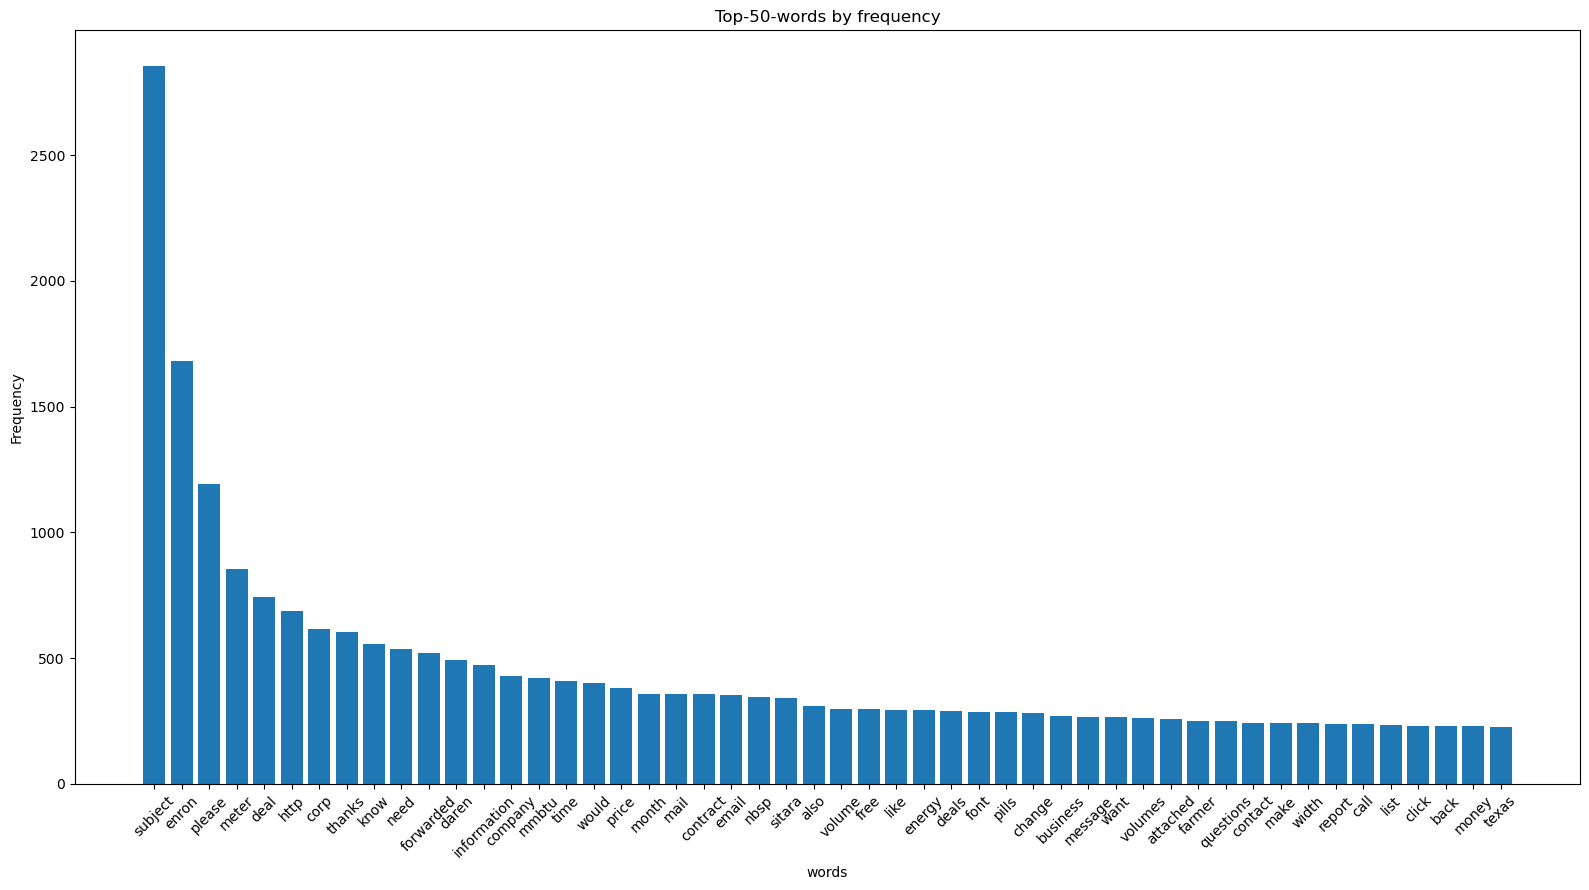

In [41]:
# change directory to output path if provided
if outputPath:
  os.chdir(f"../{outputPath}")
# feature sets from a feature definition function
word_features = get_word_features(emaildocsCleaned)

### **Vectorization & Feature Extraction**

A feature set refers to the input attributes or characteristics extracted from your data that the model uses to make predictions. Once we obtain the bag of words, convert each word into a vector based on its presence or absence in each email.

Example; if the bag of words is:\
`{"Congratulations", "price", "lottery", "appointment", "street", "tax"}`.

Email:\
"Congratulations, you have won a lottery" → `{"Congratulations": True, "price": False, "lottery":True, "appointment":False, "street":False, "tax":False}`

In [42]:
# Feature extraction function
def extract_features(email_tokens, word_features):
  return {word: (word in email_tokens) for word in word_features}

# apply feature extraction on the cleaned email tokens from the corpus (emaildocsCleaned)
feature_sets = [(extract_features(email, word_features), label) for email, label in emaildocsCleaned]

In [43]:
print(feature_sets[0])

({'subject': True, 'enron': True, 'please': True, 'meter': False, 'deal': False, 'http': False, 'corp': True, 'thanks': True, 'know': False, 'need': False, 'forwarded': True, 'daren': False, 'information': False, 'company': True, 'mmbtu': True, 'time': False, 'would': False, 'price': False, 'month': False, 'mail': False, 'contract': False, 'email': False, 'nbsp': False, 'sitara': True, 'also': False, 'volume': False, 'free': False, 'like': False, 'energy': False, 'deals': False, 'font': False, 'pills': False, 'change': False, 'business': False, 'message': False, 'want': False, 'volumes': False, 'attached': False, 'farmer': False, 'questions': False, 'contact': False, 'make': False, 'width': False, 'report': False, 'call': False, 'list': False, 'click': False, 'back': False, 'money': False, 'texas': False, 'could': False, 'chokshi': False, 'robert': False, 'height': False, 'order': False, 'following': False, 'forward': False, 'production': False, 'january': False, 'march': False, 'state

## **Model Implementation & Selection**

In [44]:
# train classifier and show performance in cross-validation
n = int(NTotal*0.8)
train_data = feature_sets[:n]
test_data = feature_sets[n:]

### **Model 1: Naive bayes: Baseline**

In [45]:
# Train classifier
classifier = NaiveBayesClassifier.train(train_data)

# Get predictions for test data
predicted_labels = [classifier.classify(features) for features, label in test_data]
true_labels = [label for features, label in test_data]

In [46]:
# Define lists for capuirng Accuracy and Recall values
Accuracy_list = []
Recall_list = []

# Evaluate classifier
Accuracy_list.append(accuracy(classifier, test_data))
print("\nAccuracy:", accuracy(classifier, test_data))
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["spam", "ham"])
print(f"Confusion Matrix:\n{cm}")

# Classification report
report = classification_report(true_labels, predicted_labels)
print(f"Classification Report:\n{report}")
Recall_list.append(recall_score(true_labels, predicted_labels, pos_label="spam"))

# Informative Features
print("\n20 most informative features :")
classifier.show_most_informative_features(20)


Accuracy: 0.9775
Confusion Matrix:
[[192   0]
 [  9 199]]
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       208
        spam       0.96      1.00      0.98       192

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400


20 most informative features :
Most Informative Features
                 changes = True              ham : spam   =     50.0 : 1.0
                   steve = True              ham : spam   =     41.8 : 1.0
                    html = True             spam : ham    =     38.9 : 1.0
                  brenda = True              ham : spam   =     36.4 : 1.0
                  meters = True              ham : spam   =     36.4 : 1.0
                  jackie = True              ham : spam   =     34.3 : 1.0
                  howard = True              ham : spam   =     31.6 : 1.0
        

### **Model 2: Naive Bayes (Only Nouns and Verbs)**

In [47]:
# POS tagging
email_pos_tags = [(pos_tag(email),label) for email, label in emaildocsCleaned]

Extract features using `get_word_features()` but only that are nouns or verbs. So first we need to filter out the words that are not nouns or verbs.

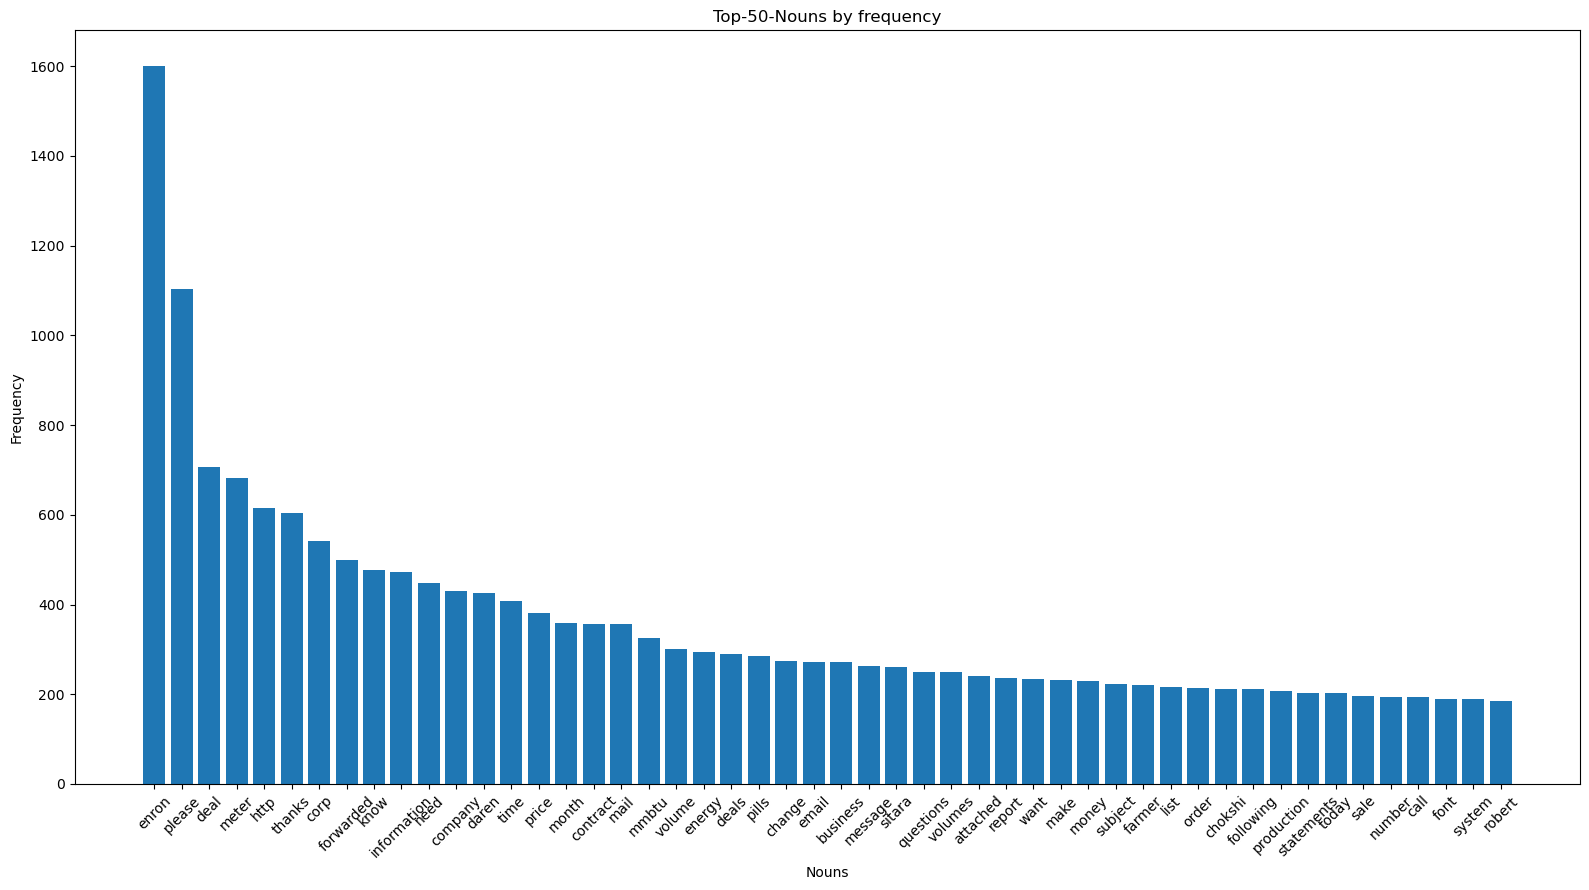

In [48]:
nouns_verbs = []
for email, label in email_pos_tags:
    nouns_verbs.append( ([word for word, pos in email if pos.startswith('NN') or pos.startswith('VB')], label) )

# feature sets from a feature definition function
word_features_nouns_verbs = get_word_features(nouns_verbs, type = 'Nouns')

In [49]:
feature_sets = [(extract_features(email, word_features_nouns_verbs), label) for email, label in emaildocsCleaned]

In [50]:
# train classifier and show performance in cross-validation
n = int(NTotal*0.8)
random.shuffle(feature_sets)
train_data = feature_sets[:n]
test_data = feature_sets[n:]

In [51]:
# Train classifier for the new set of features
classifier_model2 = NaiveBayesClassifier.train(train_data)

# Get predictions for test data
predicted_labels_nouns_verbs = [classifier_model2.classify(features) for features, label in test_data]
true_labels_nouns_verbs      = [label for features, label in test_data]

In [52]:
# Evaluate classifier for model 2
Accuracy_list.append(accuracy(classifier_model2, test_data))
print("\nAccuracy:", accuracy(classifier_model2, test_data))
# Confusion matrix
cm = confusion_matrix(true_labels_nouns_verbs, predicted_labels_nouns_verbs, labels=["spam", "ham"])
print(f"Confusion Matrix:\n{cm}")

# Classification report 
report_nouns_verbs = classification_report(true_labels_nouns_verbs, predicted_labels_nouns_verbs)
print(f"Classification Report :\n{report_nouns_verbs}")
Recall_list.append(recall_score(true_labels_nouns_verbs, predicted_labels_nouns_verbs, pos_label="spam"))

# Informative Features - nouns and Verbs
print("\n20 most informative features -Nouns/Verbs :")
classifier_model2.show_most_informative_features(20)


Accuracy: 0.9875
Confusion Matrix:
[[199   0]
 [  5 196]]
Classification Report :
              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       201
        spam       0.98      1.00      0.99       199

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


20 most informative features -Nouns/Verbs :
Most Informative Features
                  jackie = True              ham : spam   =     41.1 : 1.0
                   steve = True              ham : spam   =     37.8 : 1.0
                  meters = True              ham : spam   =     35.1 : 1.0
                  farmer = True              ham : spam   =     34.8 : 1.0
                  brenda = True              ham : spam   =     34.4 : 1.0
                    camp = True              ham : spam   =     31.1 : 1.0
                attached = True              ham : spam   =     30.0 

### **Model 3: Naive Bayes (Adjectives & Adverbs)**

In [53]:
adj_adverbs = []
for email, label in email_pos_tags:
    adj_adverbs.append( ([word for word, pos in email if pos in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS')], label) )

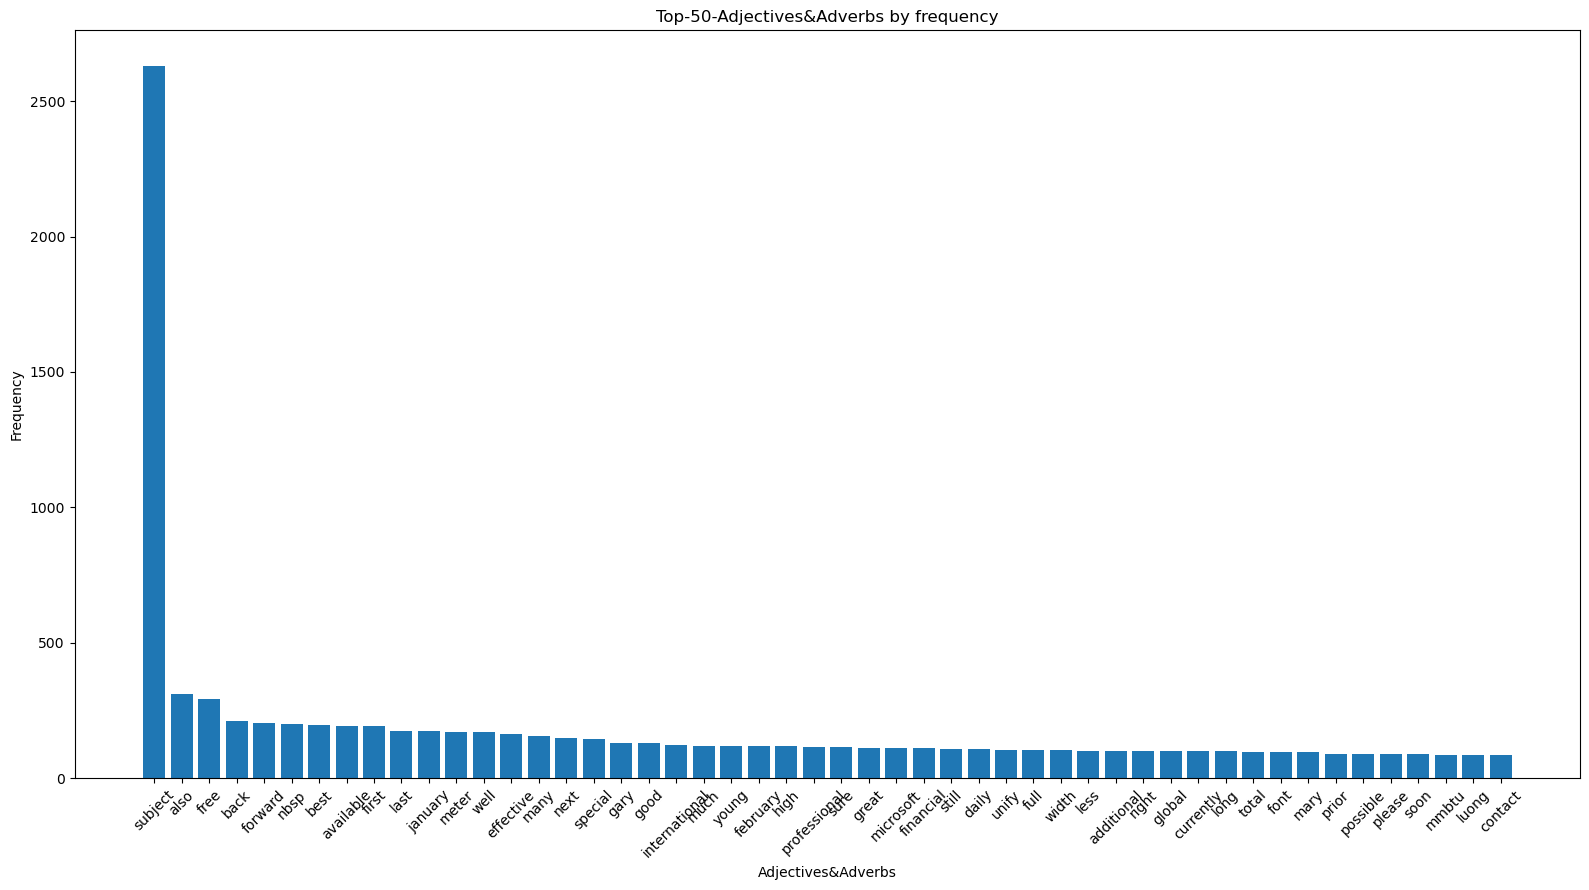

In [54]:
# feature sets from a feature definition function
word_features_adj_adverbs = get_word_features(adj_adverbs, type = 'Adjectives&Adverbs')

feature_sets = [(extract_features(email, word_features_adj_adverbs), label) for email, label in emaildocsCleaned]

In [55]:
# train classifier and show performance in cross-validation
n = int(NTotal*0.8)
random.shuffle(feature_sets)
train_data = feature_sets[:n]
test_data = feature_sets[n:]

In [56]:
# Train classifier for the new set of features
classifier_model3 = NaiveBayesClassifier.train(train_data)

# Get predictions for test data
predicted_labels_adj_adverbs = [classifier_model3.classify(features) for features, label in test_data]
true_labels_adj_adverbs      = [label for features, label in test_data]

# Evaluate classifier for model 3
Accuracy_list.append(accuracy(classifier_model3, test_data)) 
print("\nAccuracy:", accuracy(classifier_model3, test_data))
# Confusion matrix
cm = confusion_matrix(true_labels_adj_adverbs, predicted_labels_adj_adverbs, labels=["spam", "ham"])
print(f"Confusion Matrix:\n{cm}")

# Classification report 
report_adj_adverbs = classification_report(true_labels_adj_adverbs, predicted_labels_adj_adverbs)
print(f"Classification Report :\n{report_adj_adverbs}")
Recall_list.append(recall_score(true_labels_adj_adverbs, predicted_labels_adj_adverbs, pos_label="spam"))

# Informative Features - Adjectives and Adverbs
print("\n20 most informative features -Adjectives/Adverbs :")
classifier_model3.show_most_informative_features(20)


Accuracy: 0.955
Confusion Matrix:
[[212   5]
 [ 13 170]]
Classification Report :
              precision    recall  f1-score   support

         ham       0.97      0.93      0.95       183
        spam       0.94      0.98      0.96       217

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400


20 most informative features -Adjectives/Adverbs :
Most Informative Features
                    html = True             spam : ham    =     40.0 : 1.0
                  jackie = True              ham : spam   =     35.5 : 1.0
                  farmer = True              ham : spam   =     33.8 : 1.0
                 windows = True             spam : ham    =     31.0 : 1.0
                   lloyd = True              ham : spam   =     30.4 : 1.0
                   julie = True              ham : spam   =     29.7 : 1.0
                    corp = True              ham : spam   =    

### **Model 4: Naive Bayes with Polarity Scores**

In [57]:
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores using polarity_scores() for each email
def calculate_sentiment_scores(email_tokens):
    # Join tokens into a single string
    email_text = ' '.join(email_tokens)
    # Get sentiment score for the email
    sentiment_score = sia.polarity_scores(email_text)
    return sentiment_score['compound']

# Feature extraction function
def extract_features_sentiment(email_tokens, word_features):
# Extract regular word features (if the word is in the email)
    features = {word: (word in email_tokens) for word in word_features} 
    # Calculate sentiment score
    sentiment_score = calculate_sentiment_scores(email_tokens)  
    # Add sentiment score as a feature
    features['sentiment_score'] = sentiment_score

    return features


In [58]:
# apply feature extraction on the cleaned email tokens from the corpus (emaildocsCleaned)
feature_sets = [(extract_features_sentiment(email, word_features), label) for email, label in emaildocsCleaned]

In [59]:
feature_sets[1][0]['sentiment_score'] 

0.6369

In [60]:
# train classifier and show performance in cross-validation
random.shuffle(feature_sets)
train_data = feature_sets[:n]
test_data = feature_sets[n:]

In [61]:
# Train classifier for the new set of features
classifier_model4 = NaiveBayesClassifier.train(train_data)

# Get predictions for test data
predicted_labels_sentiment_score = [classifier_model4.classify(features) for features, label in test_data]
true_labels_sentiment_score      = [label for features, label in test_data]

In [62]:
# Evaluate classifier for model 3
Accuracy_list.append(accuracy(classifier_model4, test_data)) 
print("\nAccuracy:", accuracy(classifier_model4, test_data))
# Confusion matrix
cm = confusion_matrix(true_labels_sentiment_score, predicted_labels_sentiment_score, labels=["spam", "ham"])
print(f"Confusion Matrix:\n{cm}")

# Classification report 
report_sentiment_score = classification_report(true_labels_sentiment_score, predicted_labels_sentiment_score)
print(f"Classification Report :\n{report_sentiment_score}")
Recall_list.append(recall_score(true_labels_sentiment_score, predicted_labels_sentiment_score, pos_label="spam"))


Accuracy: 0.9525
Confusion Matrix:
[[197   0]
 [ 19 184]]
Classification Report :
              precision    recall  f1-score   support

         ham       1.00      0.91      0.95       203
        spam       0.91      1.00      0.95       197

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



## **Comparison Report**

In [63]:
# Comparison Report
comp_report = pd.DataFrame({'Model':['Baseline', 'POS-Nouns/Verbs','POS-Adverbs/Adjectives', 'Sentiment Score'],
                            'Accuracy':Accuracy_list,
                            'Recall':Recall_list})
print("\nComparing Results")
print(comp_report)




Comparing Results
                    Model  Accuracy    Recall
0                Baseline    0.9775  1.000000
1         POS-Nouns/Verbs    0.9875  1.000000
2  POS-Adverbs/Adjectives    0.9550  0.976959
3         Sentiment Score    0.9525  1.000000


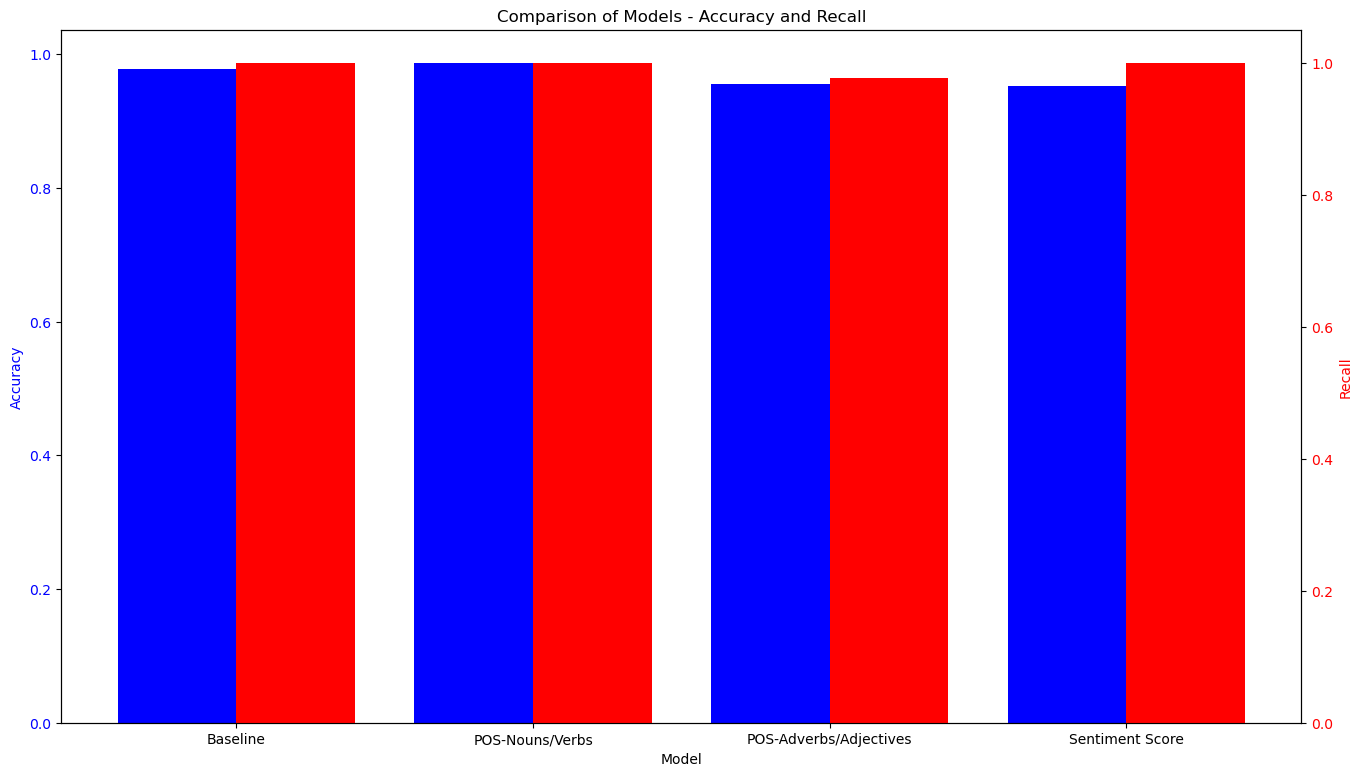

In [64]:
# Plot the results in a bar chart
X_axis = np.arange(len(comp_report['Model'])) 
fig, ax1 = plt.subplots(figsize=(16, 9))

bars1 = ax1.bar(X_axis - 0.2, comp_report['Accuracy'], 0.4, label = 'Accuracy', color='b')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(X_axis)
ax1.set_xticklabels(comp_report['Model'])

# Create a second y-axis
ax2 = ax1.twinx()
bars2 = ax2.bar(X_axis + 0.2, comp_report['Recall'], 0.4, label = 'Recall', color='r')
ax2.set_ylabel('Recall', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Comparison of Models - Accuracy and Recall") 
# Save the plot as an image
plt.savefig(f"comparison_plot.png")